<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/Final_v1/hybrid_model/hybrid_model_(custom_cnn_%2B_vit_b16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries



In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import pathlib

In [ ]:
import tensorflow_hub as hub

In [ ]:
import os

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!pip install vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train'

In [ ]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/Corn (Maize)/Train')

In [ ]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 7326 files belonging to 4 classes.
Using 5129 files for training.
Using 2197 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

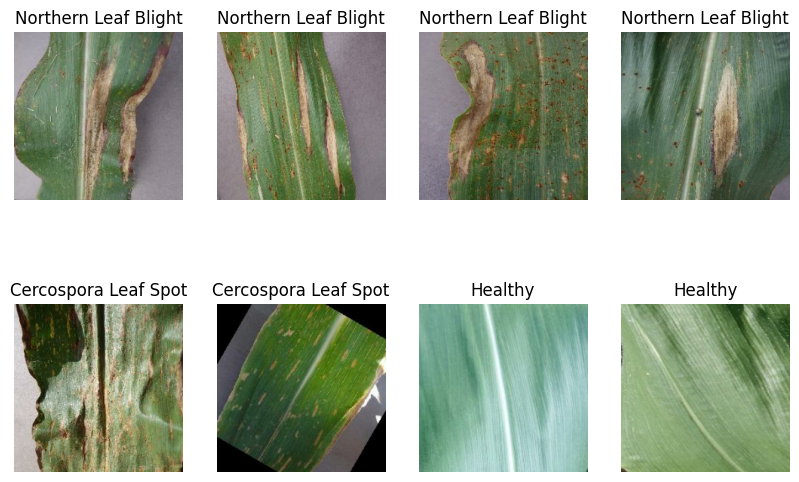

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 69


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 35
Number of test batches: 34


# Custom Layers

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Loading base model

The weights in this model have been obtained by training on the ILSVRC-2012-CLS dataset for image classification ("Imagenet").

In [ ]:
# Load a pre-trained ViT model without the top classification layer
vit_model = vit.vit_b16(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


# CNN model

In [ ]:
def create_cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = rescale(inputs)
    x = data_augmentation(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Hybrid model 1

In [ ]:
def create_hybrid_model_with_pretrained_vit(input_shape, num_classes, vit_feature_extractor,cnn_model):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Data augmentation and rescaling
    x = data_augmentation(inputs)
    x = rescale(x)

    # Pretrained ViT feature extractor
    vit_features = vit_feature_extractor(x)

    # Custom CNN component
    cnn_model = create_cnn_model(input_shape, num_classes)
    cnn_features = cnn_model(inputs)

    # Concatenate the outputs of ViT and CNN
    combined_features = layers.Concatenate()([vit_features, cnn_features])

    # Fully connected layers
    x = layers.Dense(512, activation='relu')(combined_features)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    hybrid_model = models.Model(inputs=inputs, outputs=outputs)
    hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    hybrid_model.summary()
    return hybrid_model

## Train hybrid model 1

In [ ]:
input_shape = (224,224,3)
num_classes = len(class_names)
epochs = 150

In [ ]:
cnn_fe = create_cnn_model(input_shape,num_classes)
vit_fe = vit_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                             

In [ ]:
num_classes

4

In [ ]:
hybrid_model = create_hybrid_model_with_pretrained_vit(input_shape, num_classes, vit_fe,cnn_fe)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                           

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Final_v1/hybrid_model/trained_hybrid_models'

In [ ]:
def runExperiment(train_ds, validation_ds, test_ds, input_shape, num_classes, hybrid_model, epochs):

    # Train the model
    history = hybrid_model.fit(
        train_ds,
        validation_data=validation_ds,
        verbose=1,
        epochs=epochs,
        callbacks=[early_stopping],
        batch_size=32
    )

    hybrid_model.save(os.path.join(model_path, f'hybrid_model_(custom cnn + vit_b16).keras'))

    # Evaluate the model
    test_loss, test_accuracy = hybrid_model.evaluate(test_ds)
    print(f'Test accuracy: {test_accuracy}')

    return history, test_loss, test_accuracy

In [ ]:
history, test_loss, test_accuracy = runExperiment(train_ds, validation_dataset, test_dataset, input_shape, num_classes, hybrid_model, epochs)

Epoch 1/150
161/161 [==============================] - 1148s 7s/step - loss: 0.5706 - accuracy: 0.7699 - val_loss: 0.6124 - val_accuracy: 0.8954
Epoch 2/150
161/161 [==============================] - 253s 2s/step - loss: 0.2229 - accuracy: 0.9208 - val_loss: 1.3806 - val_accuracy: 0.6285
Epoch 3/150
161/161 [==============================] - 252s 2s/step - loss: 0.1932 - accuracy: 0.9347 - val_loss: 0.8671 - val_accuracy: 0.6763
Epoch 4/150
161/161 [==============================] - 252s 2s/step - loss: 0.1709 - accuracy: 0.9419 - val_loss: 0.2568 - val_accuracy: 0.9098
Epoch 5/150
161/161 [==============================] - 252s 2s/step - loss: 0.1440 - accuracy: 0.9520 - val_loss: 0.0888 - val_accuracy: 0.9702
Epoch 6/150
161/161 [==============================] - 251s 2s/step - loss: 0.1384 - accuracy: 0.9528 - val_loss: 0.1906 - val_accuracy: 0.9459
Epoch 7/150
161/161 [==============================] - 252s 2s/step - loss: 0.1398 - accuracy: 0.9548 - val_loss: 0.1961 - val_accuracy

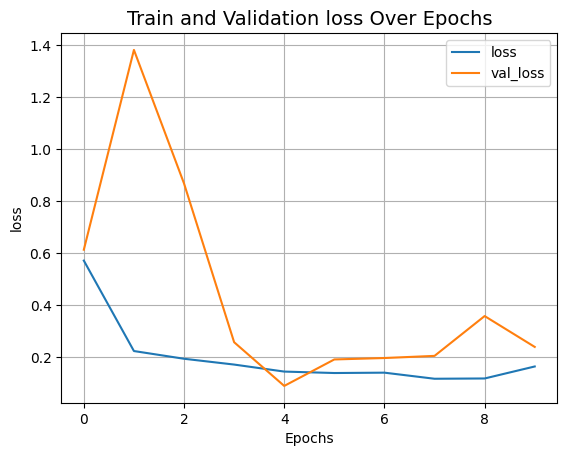

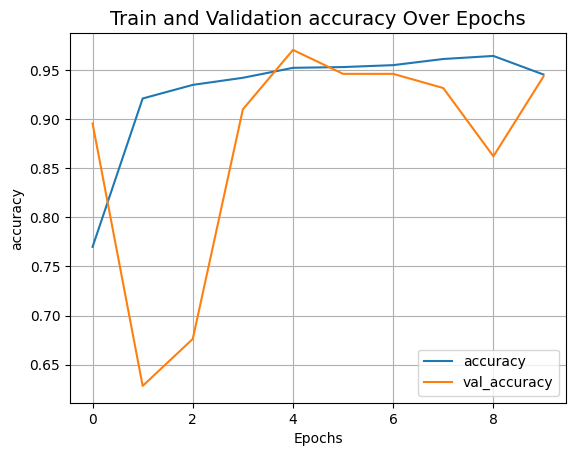

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

# Confusion matrix

In [ ]:
predictions = hybrid_model.predict(test_dataset)
predictions

34/34 [==============================] - 17s 508ms/step


array([[9.7503847e-01, 5.1443180e-04, 7.0540569e-05, 2.4376560e-02],
       [3.4941506e-05, 9.9993885e-01, 1.0092899e-05, 1.6131622e-05],
       [3.7904091e-03, 2.7649030e-06, 3.8883695e-06, 9.9620289e-01],
       ...,
       [1.6222688e-04, 1.7478122e-04, 9.9940705e-01, 2.5588332e-04],
       [7.9295281e-03, 8.7027920e-06, 1.2008043e-05, 9.9204975e-01],
       [1.0238310e-04, 9.9971074e-01, 1.2251620e-04, 6.4321270e-05]],
      dtype=float32)

In [ ]:
y_pred_classes = np.argmax(predictions, axis=1)
y_pred_classes

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([0, 1, 3, ..., 2, 3, 1], dtype=int32)

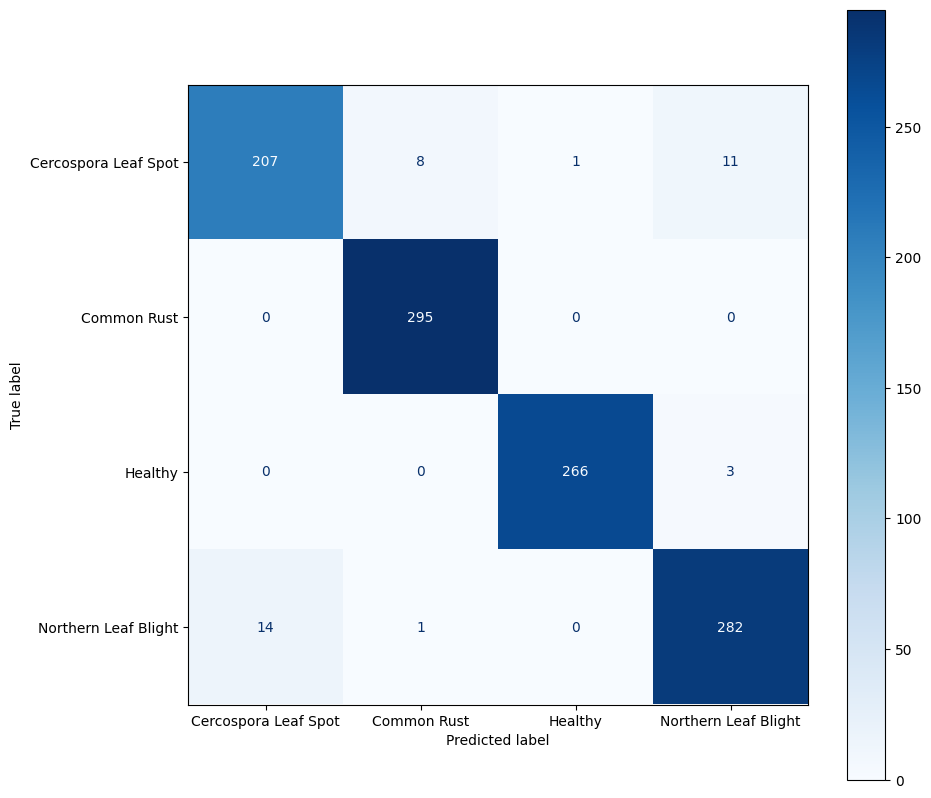

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()